# 0. Imports

In [2]:
# for data handling and manipulation:
import pandas as pd
import numpy as np

# for os handling
import os

# for pre-processing
from sklearn.preprocessing import StandardScaler

# import the classifiers to fit:
from sklearn.linear_model import LogisticRegression

# import metrics
from sklearn.metrics import fbeta_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, make_scorer

# for tabulating results
from tabulate import tabulate

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# for handling warnings
import warnings

# for hyper-parameter tuning
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import GridSearchCV

In [3]:
# Reading the train, test and validation data into this notebook 

X_train_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_train_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_train_gray = X_train_gray.to_numpy()

y_train = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_train.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_train = y_train.to_numpy(dtype = 'int64').flatten()

X_val_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_val_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_val_gray = X_val_gray.to_numpy()

y_val = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_val.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_val = y_val.to_numpy(dtype = 'int64').flatten()

X_test_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_test_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_test_gray = X_test_gray.to_numpy()

y_test = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_test.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_test = y_test.to_numpy(dtype = 'int64').flatten()

In [4]:
X_train_gray.shape, y_train.shape, X_val_gray.shape, y_val.shape, X_test_gray.shape, y_test.shape

((791, 98), (791,), (98, 98), (98,), (100, 98), (100,))

In [5]:
X_final_train_gray = np.concatenate((X_train_gray, X_val_gray), axis = 0)
y_train_final = np.concatenate((y_train, y_val), axis = 0)

## Function to calculate metrics

In [6]:
def calculate_metrics(y_pred, y_true,):
    
    with warnings.catch_warnings():
        
        warnings.filterwarnings('ignore')
        # calculate accuracy:
        temp = round(accuracy_score(y_true, y_pred),2)
        print('Accuracy in detecting Accident class: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')
        
        my_data = []
        cr = classification_report(y_true, y_pred, output_dict = True)

        # calculate precision:
        my_data.append(['Precision',round(cr['0']['precision'],2), round(cr['1']['precision'],2)])

        # calculate recall:
        my_data.append(['Recall',round(cr['0']['recall'],2), round(cr['1']['recall'],2)])

        # f1-score:
        my_data.append(['f1-score',round(cr['0']['f1-score'],2), round(cr['1']['f1-score'],2)])

        head = ['Metric','Non-Accident images','Accident images']

        print(tabulate(my_data, headers = head, tablefmt = 'grid'))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate sensitivity (recall of positive class for binary classification)
        temp = round(cr['1']['recall'],2)
        print('Sensitivity/ ability to correctly classifiy to Accident class is: {}'.format(temp))
    
        # calculate specificity (recall of negative class for binary classification)
        temp = round(cr['0']['recall'],2)
        print('Specificity/ ability to correctly classifiy to Non-Accident class is: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate f1-beta score:
        print('Fbeta score with beta = 1.5 is: {}'.format(round(fbeta_score(y_true, y_pred,beta = 1.4),2)))
        print('\n------------------------------------------------------------------------------------------\n')

        # Confusion matrix:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
        disp.plot()
        plt.title('Confusion Matrix')
        plt.show()
        print('\n------------------------------------------------------------------------------------------\n')

        # ROC curve:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, marker = 'o')
        plt.xlabel('% of Non-Accidents incorrectly classified')
        plt.ylabel('% of Accidents correctly classified')
        plt.title('ROC Curve')
        plt.show()
        print('\n------------------------------------------------------------------------------------------\n')
        temp = round(auc(fpr, tpr),2)
        print('AUC score is: {}'.format(temp))

    return 

# Fitting Logistic Regression

## On grayscale images

## Scale the data

In [7]:
scaler = StandardScaler()
X_train_gray_sc = scaler.fit_transform(X_final_train_gray)
X_test_gray_sc = scaler.transform(X_test_gray)

In [8]:
X_train_gray_sc.shape, X_test_gray_sc.shape

((889, 98), (100, 98))

### Let's formally do hyper-parameter tuning, using Bayes Optimization. The default parameters are also an option to use for both Bayes and Grid search CV, if they indeed have the best generalizing capability, then it will get detected.

In [58]:
parameters = {'penalty': ['l1','l2','elasticnet'],'C': Real(0.0001,5,prior = 'uniform'), 'fit_intercept':[True, False],
             'intercept_scaling': Real(1,5, 'uniform'), 'l1_ratio' : Real(0,1, 'uniform')}  
fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [84]:
opt = BayesSearchCV(LogisticRegression(random_state = 5000, class_weight = {0:1, 1:1.5}, max_iter= 5000, solver= 'saga'),
                    parameters, n_iter = 100, scoring = fbeta_scorer, verbose = 5, random_state = 5000, cv = 3)

np.int = int  # numpy doesn't have int attribute now, to avoid an error in existing code, need to use int in place of this.

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=4.0, fit_intercept=False, intercept_scaling=5, l1_ratio=0.2, penalty=l1;, score=0.780 total time=   1.3s
[CV 2/3] END C=4.0, fit_intercept=False, intercept_scaling=5, l1_ratio=0.2, penalty=l1;, score=0.813 total time=   1.3s
[CV 3/3] END C=4.0, fit_intercept=False, intercept_scaling=5, l1_ratio=0.2, penalty=l1;, score=0.755 total time=   1.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=2.0, fit_intercept=True, intercept_scaling=3, l1_ratio=0.2, penalty=l2;, score=0.768 total time=   0.5s
[CV 2/3] END C=2.0, fit_intercept=True, intercept_scaling=3, l1_ratio=0.2, penalty=l2;, score=0.810 total time=   0.3s
[CV 3/3] END C=2.0, fit_intercept=True, intercept_scaling=3, l1_ratio=0.2, penalty=l2;, score=0.749 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END C=5.0, fit_intercept=False, intercept_scaling=4, l1_ratio=0.2, penalty=elasticnet;, score=0.7

In [96]:
print('Best score using 3-fold cross validation on train data:', round(opt.best_score_,6))

Best score using 3-fold cross validation on train data: 0.791287


In [87]:
print('Best parameters:', opt.best_params_)

Best parameters: OrderedDict([('C', 4.0), ('fit_intercept', True), ('intercept_scaling', 3), ('l1_ratio', 0.8), ('penalty', 'l1')])


## Trying Grid search CV

In [88]:
parameters = {'penalty': ['l1','l2','elasticnet'],'C': [0.0001,0.001, 0.01,0.1,2,3,4,5], 'fit_intercept':[True, False],
             'intercept_scaling': [1,2,3,4,5], 'l1_ratio' : np.arange(0,1,0.2)}  
fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [89]:
opt_gs = GridSearchCV(LogisticRegression(random_state = 5000, class_weight = {0:1, 1:1.5}, max_iter= 5000, solver= 'saga'),
                    parameters, scoring = fbeta_scorer, verbose = 5, cv = 3)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_gs.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
[CV 1/3] END C=0.0001, fit_intercept=True, intercept_scaling=1, l1_ratio=0.0, penalty=l1;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, fit_intercept=True, intercept_scaling=1, l1_ratio=0.0, penalty=l1;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, fit_intercept=True, intercept_scaling=1, l1_ratio=0.0, penalty=l1;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, fit_intercept=True, intercept_scaling=1, l1_ratio=0.0, penalty=l2;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, fit_intercept=True, intercept_scaling=1, l1_ratio=0.0, penalty=l2;, score=0.721 total time=   0.0s
[CV 3/3] END C=0.0001, fit_intercept=True, intercept_scaling=1, l1_ratio=0.0, penalty=l2;, score=0.721 total time=   0.0s
[CV 1/3] END C=0.0001, fit_intercept=True, intercept_scaling=1, l1_ratio=0.0, penalty=elasticnet;, score=0.723 total time=   0.0s
[CV 2/3] END C=0.0001, fit_intercept=True, intercept_scaling=1, l1_ratio=

In [95]:
print('Best score using a 3-fold cross validation:', round(opt_gs.best_score_,6))

Best score using a 3-fold cross validation: 0.791287


In [92]:
print('Best parameters using a 3-fold cross validation:', opt_gs.best_params_)

Best parameters using a 3-fold cross validation: {'C': 4, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.0, 'penalty': 'l1'}


### Both Bayes Search CV and Grid Search CV give parameters with same best scores upto 6 decimal places. Suggests, we can use parameters found by either of the two.

In [9]:
# But Grid Search has identified 'intercept scaling' at the edge of the given range. 

parameters = {'penalty': ['l1','l2','elasticnet'],'C': [0.0001,0.001, 0.01,0.1,2,3,4,5], 'fit_intercept':[True, False],
             'intercept_scaling': [0.1, 0.5, 0.8, 1,2], 'l1_ratio' : np.arange(0,1,0.2)}  
fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)                                                                     

In [12]:
opt_gs2 = GridSearchCV(LogisticRegression(random_state = 5000, class_weight = {0:1, 1:1.5}, max_iter= 5000, solver= 'saga'),
                    parameters, scoring = fbeta_scorer, verbose = 5, cv = 3, n_jobs= -1)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_gs.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


In [15]:
print('Best score using a 3-fold cross validation:', round(opt_gs2.best_score_,6))

Best score using a 3-fold cross validation: 0.791287


In [16]:
print('Best parameters using a 3-fold cross validation:', opt_gs2.best_params_)

Best parameters using a 3-fold cross validation: {'C': 4, 'fit_intercept': True, 'intercept_scaling': 0.1, 'l1_ratio': 0.0, 'penalty': 'l1'}


But the score reduced when we extended the search space for parameters which had edge cases selected as best values.

In [13]:
best_est = LogisticRegression(random_state = 5000, class_weight = {0:1, 1:1.5}, max_iter= 5000, solver= 'saga',**opt_gs.best_params_)
best_est

LogisticRegression(C=4, class_weight={0: 1, 1: 1.5}, intercept_scaling=0.1,
                   l1_ratio=0.0, max_iter=5000, penalty='l1', random_state=5000,
                   solver='saga')

In [14]:
best_est.fit(X_train_gray_sc, y_train_final)

C:\Users\DIKSHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


LogisticRegression(C=4, class_weight={0: 1, 1: 1.5}, intercept_scaling=0.1,
                   l1_ratio=0.0, max_iter=5000, penalty='l1', random_state=5000,
                   solver='saga')

Accuracy in detecting Accident class: 0.83

------------------------------------------------------------------------------------------

+-----------+-----------------------+-------------------+
| Metric    |   Non-Accident images |   Accident images |
+===========+=======================+===================+
| Precision |                  0.83 |              0.83 |
+-----------+-----------------------+-------------------+
| Recall    |                  0.85 |              0.81 |
+-----------+-----------------------+-------------------+
| f1-score  |                  0.84 |              0.82 |
+-----------+-----------------------+-------------------+

------------------------------------------------------------------------------------------

Sensitivity/ ability to correctly classifiy to Accident class is: 0.81
Specificity/ ability to correctly classifiy to Non-Accident class is: 0.85

------------------------------------------------------------------------------------------

Fbeta scor

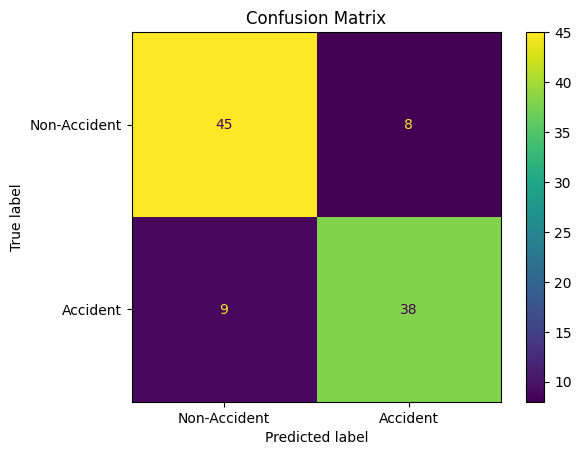


------------------------------------------------------------------------------------------



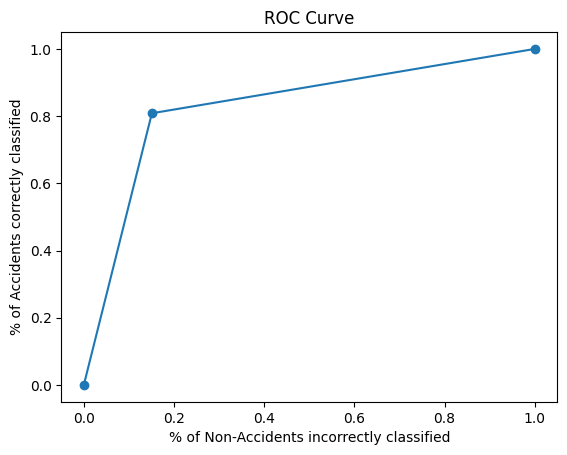


------------------------------------------------------------------------------------------

AUC score is: 0.83


In [100]:
pred_gray_test = best_est.predict(X_test_gray_sc)
calculate_metrics(pred_gray_test, y_test)

So, the best we could do using **Logistic Regression** is a test set fbeta score (beta = 1.4) of 0.81, with the parameters:

- random_state : 5000
- class_weight : {0:1, 1:1.5},
- max_iter: 5000,
- solver: 'saga'
- C : 4,
- 'fit_intercept': True,
- 'intercept_scaling': 1
- 'penalty': 'l1'